### Importing useful modules
##### fetch_20newsgroups dataset from skearn.datasets
##### stopwords from nltk

In [1]:
from sklearn.datasets import fetch_20newsgroups
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.naive_bayes import MultinomialNB

### Here I am fetching the data and analyzing it

In [2]:
data=fetch_20newsgroups()
categories1=data.target_names ## categories into which text will be classified
train=fetch_20newsgroups(subset='train',categories=categories1) ##training data
print(len(categories1))
print(len(train.data))

20
11314


In [5]:
stopwds=set(stopwords.words('english')) ### These are the words which we don't want to include in our vocabulary
punctuations=list(string.punctuation) ###Thses are the puctuation marks
stopwds.update(punctuations) ## We are updating the vacoabulary with punctuations 
data.keys() ## Analyzing the keys of the data

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [6]:
docs=train.data ###Now taking the data from training data
categ=train.target ###Fetching the categories of the docs
doc_mod=[word_tokenize(doc) for doc in docs] ###word_tokenize will split the docs into words


In [8]:
X_train,X_test,Y_train,Y_test=train_test_split(doc_mod,categ,random_state=1) ### Splitting the data into training and testing

In [9]:
allwords=[] ##In this list we will update the words in docs not on stopwords
for doc in X_train:
    for word in doc:
        if((word.lower() not in stopwds) and len(word)!=1 and len(word)!=2 and word!="n't" and word[0]!="." and word[0]!="'"):
            allwords.append(word)

In [10]:
len(allwords) ###finding the number of words

1385691

In [11]:
def freq(allwords):
    dic=dict()
    for word in allwords:
        if(word in dic.keys()):
            dic[word]+=1
        else:
            dic[word]=1;
    return dic
dic1=freq(allwords) ## Here we are making a dictionary of words and counting the number of times a word is occuring


In [12]:
wds=np.array([i for i in dic1.keys()]) ## Here is the array for final words
freqs=np.array([i for i in dic1.values()]) ## This the array of the frequencies of final words we have

In [13]:
### In this cell, we have firsty sorted the array in ascending order and the reversed it to get the descending one
wds=wds[np.argsort(freqs)][::-1] 
freqs=np.sort(freqs)[::-1]

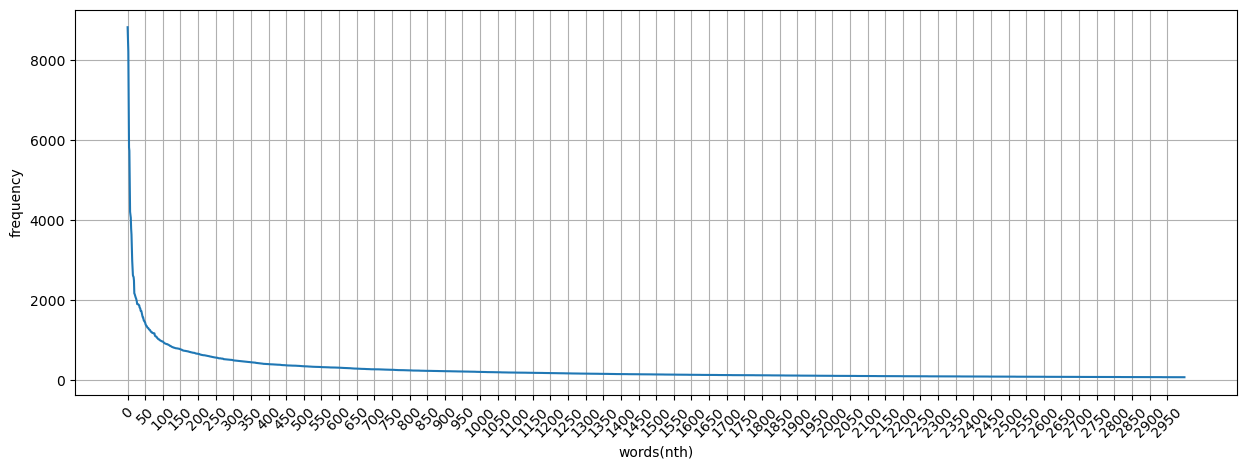

In [14]:
### In this cell, we are plotting frequency to word graph
import matplotlib.pyplot as plt
lower=0  ##lower limit
upper=3000 ##Upper limit
diff=50 ###step size
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(freqs))[lower:upper],freqs[lower:upper])
plt.xlabel("words(nth)") ## Labelling
plt.ylabel("frequency")
plt.xticks(np.arange(lower,upper,50),rotation=45) ## adjusting xtixks
plt.grid()
plt.show()

In [15]:
feature=wds[20:4000]
#here we are choosing the words from 20 to 4000 

### The next function is to modify the data into proper x train so that the this can be used to further to classify the docs. A 2d numpy array is made with rows as docs and columns as words/fetaures

In [16]:
def data_mod(X_data,feature):
    moddata=np.zeros((len(X_data),len(feature))) ## 2d numpy array initialized to zero i for the docs and j for features/words
    for i in range(len(X_data)):
        curdoc=X_data[i]
        for word in curdoc:
            if word in feature:
                for j in range(len(feature)):
                    if feature[j]==word:
                        moddata[i][j]+=1
    return moddata                    
    

In [17]:
X_train_mod=data_mod(X_train,feature) ##Modifying Xtrain
X_test_mod=data_mod(X_test,feature) ###Modifying XTest


### Trying out the inbuilt Multinomial Naive Bayes Classifier

In [18]:
clf=MultinomialNB()
clf.fit(X_train_mod,Y_train) ## Fit the data
clf.score(X_test_mod,Y_test)  ### Calculating the score

0.8218451749734889

### Now we implement our own Multinomial Naive Bayes Classifier
    

In [19]:
Y_train ## Analysing the Ytrain Values

array([16,  0,  9, ..., 15,  6,  2], dtype=int64)

#### This the fit function which will make a dictionary for us where each class will ve the key at first level then at the second words will be the keys which will store the frequency of each word in the particular class

In [36]:
def fit(X_train_mod, Y_train):
    result = dict()
    class_values = set(Y_train)
    for current_class in class_values:
        result[current_class] = {}
        result["total_data"] = len(Y_train)
        current_class_rows = (Y_train == current_class) ## selecting docs of current class
        X_train_current = X_train_mod[current_class_rows] ## selected Xtrain
        Y_train_current = Y_train[current_class_rows] ## selected Ytrain
        
        result[current_class]["total_countofdoc"] = len(Y_train_current) ## Cout of the total docs of the particular class
        count=0
        ##Loop to store the values of the aprticular word
        for j in range(len(feature)):
            result[current_class][feature[j]] = X_train_current[:,j].sum()
            count+=X_train_current[:,j].sum()
           
        result[current_class]["totalwords"]=count     ### Count of total words of that class 
    return result

In [37]:
dictionary = fit(X_train_mod, Y_train) ## Fetching the dictionary using the fit function

In [53]:
### This function claculates the probabbilty of each class for us
def probability(dictionary, doc, current_class):
    output = np.log(dictionary[current_class]["total_countofdoc"]) - np.log(dictionary["total_data"])
   ##Traversing the doc for words and taking only those words which are in doc and vocabulary as well
## I have calculated the probability with Laplace correction
### Log probabilities are used
   for j in range(0,len(doc)):
        
        if(doc[j]!=0):
            count_current_class_with_word_xj = ((dictionary[current_class][feature[j]]) + 1) ##total frequency of particular word in the class
            count_current_class = dictionary[current_class]["totalwords"] + len(doc) ## total words in current class
            current_xj_probablity = np.log(count_current_class_with_word_xj) - np.log(count_current_class)           # By taking log values, we prevent multiplication with a 0 probability
            output = output + current_xj_probablity
    return output

In [34]:
### This function predicts for e single point. It calculates probability for all classes and returns only the one with maximum probability
def predictSinglePoint(dictionary, doc):
    classes = dictionary.keys()
    best_p = -1000
    best_class = -1
    first_run = True
    for current_class in classes:
        if (current_class == "total_data"):
            continue
        p_current_class = probability(dictionary, doc, current_class)
        if (first_run or p_current_class > best_p):             # Obtaining the class with higher probability
            best_p = p_current_class
            best_class = current_class
        first_run = False
    return best_class

In [50]:
###This function will return the Ypred for Xtest
def predict(dictionary, X_test_mod):
    y_pred = []
    for doc in X_test_mod:
        x_class = predictSinglePoint(dictionary, doc)
        y_pred.append(x_class)
    return y_pred

In [58]:
Y_pred = predict(dictionary, X_test_mod)
## This gets the Ypred for Xtest

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report")
print(classification_report(Y_test, Y_pred)) ## Printint classification report form the Ypred and Ytest
print("Confusion Matrix")
print(confusion_matrix(Y_test, Y_pred)) ## Printing confusion matrix for Ypred and Ytest
print()
print("Accuracy Score")
print(accuracy_score(Y_test, Y_pred) * 100, "%", sep="") ## printing the accuracy score for Ypred and Ytest

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       114
           1       0.58      0.72      0.65       152
           2       0.93      0.63      0.75       139
           3       0.67      0.72      0.69       152
           4       0.69      0.80      0.74       138
           5       0.85      0.74      0.79       153
           6       0.70      0.80      0.75       147
           7       0.77      0.83      0.80       137
           8       0.76      0.88      0.82       131
           9       0.87      0.96      0.91       135
          10       0.98      0.88      0.93       136
          11       0.94      0.94      0.94       145
          12       0.82      0.69      0.75       157
          13       0.89      0.89      0.89       151
          14       0.90      0.85      0.87       155
          15       0.91      0.87      0.89       159
          16       0.82      0.89      0.86       140
     

# Observations
#### I have obtained a score of 82.18% for Inbuilt Multinomial Naive Bayes
#### I have obtained an accuracy of 81.26% for our own Impelmented Naive Bayes Classifier
### Overall the accuracy is great. Looking at the classification report, it can be seen that the algorithm gave some good results for few classes and it seems like if more selected features are chosen, a further high accuracy can be obtained